# Best to Run this on Kaggle and utilize the GPU for faster training

In [1]:
import os
import collections
import pandas as pd
import numpy as np
import functools
import matplotlib.pyplot as plt
import cv2
import json

from sklearn import preprocessing

import xml.etree.ElementTree as ET

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torchvision

from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os
from albumentations import RandomRotate90
from tensorflow.keras import mixed_precision
import gc

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# # # data paths
train_csv_path = '/kaggle/input/crop-data/dataset/final_train_labels.csv'
test_csv_path = '/kaggle/input/crop-data/dataset/final_test_labels.csv'
val_csv_path = '/kaggle/input/crop-data/dataset/final_validate_labels.csv'

In [3]:
# read, train, test and validation dataset
train_data = pd.read_csv(train_csv_path)
test_data = pd.read_csv(test_csv_path)
val_data = pd.read_csv(val_csv_path) 

In [4]:
train_data['integer_label'] = train_data['integer_label'] - 1
test_data['integer_label'] = test_data['integer_label'] - 1
val_data['integer_label'] = val_data['integer_label'] - 1

In [5]:
# Get the initial shape of the DataFrame
initial_shape = train_data.shape
initial_shape

(40852, 12)

In [6]:
# Filter rows where x1 is not greater than or equal to x2
train_data = train_data[train_data['x1'] < train_data['x2']]
# Filter rows where y1 is not greater than or equal to y2
train_data = train_data[train_data['y1'] < train_data['y2']]

# Filter rows where x1 is not greater than or equal to x2
test_data = test_data[test_data['x1'] < test_data['x2']]
# Filter rows where y1 is not greater than or equal to y2
test_data = test_data[test_data['y1'] < test_data['y2']]

# Filter rows where x1 is not greater than or equal to x2
val_data = val_data[val_data['x1'] < val_data['x2']]
# Filter rows where y1 is not greater than or equal to y2
val_data = val_data[val_data['y1'] < val_data['y2']]

In [7]:
# Get the final shape of the DataFrame
final_shape = train_data.shape
final_shape

(40850, 12)

In [8]:
train_data.head()

width  height    crop               class  \
0    640     640  Tomato  Tomato Late Blight   
1    640     640    Corn        Corn Healthy   
2    640     640    Corn    Corn Common Rust   
3    640     640    Corn         Corn Streak   
4    640     640  Pepper    Pepper Leaf Curl   

                                      fname  \
0  e701b2d9-d9ef-49dd-a9b2-067ac10dff12.jpg   
1  ee11488a-d7c4-4426-898b-0153fe55d82b.jpg   
2  8c38b101-19ed-4353-b518-63e1128fc5b7.jpg   
3  627ce1e3-0354-4713-9f12-3d2db183e3e0.jpg   
4  fe203180-5056-479c-abe4-e9d4c613dc01.jpg   

                                            img_path         x1         y1  \
0  dataset/train\e701b2d9-d9ef-49dd-a9b2-067ac10d...  191.42496  306.85420   
1  dataset/train\ee11488a-d7c4-4426-898b-0153fe55...  370.76172  459.11493   
2  dataset/train\8c38b101-19ed-4353-b518-63e1128f...  167.16748  134.74731   
3  dataset/train\627ce1e3-0354-4713-9f12-3d2db183...  517.21704   73.61801   
4  dataset/train\fe203180-5056-479c-abe4-e9d4c613...  149.65358  178.65503   

          x2         y2  id  integer_label  
0  256.16083  391.27650   0             15  
1  457.52620  595.26400   1              2  
2  214.36250  330.76570   2              1  
3  535.50210  302.75104   3              3  
4  225.32716  296.88910   4              5

In [9]:
# remove .jpg extension from image_id 
train_data['img_id'] = train_data['fname'].apply(lambda x:x.split('.')).map(lambda x:x[0])
test_data['img_id'] = test_data['fname'].apply(lambda x:x.split('.')).map(lambda x:x[0])
val_data['img_id'] = val_data['fname'].apply(lambda x:x.split('.')).map(lambda x:x[0])
# df.drop(columns=['image_id'], inplace=True)
train_data.head()

width  height    crop               class  \
0    640     640  Tomato  Tomato Late Blight   
1    640     640    Corn        Corn Healthy   
2    640     640    Corn    Corn Common Rust   
3    640     640    Corn         Corn Streak   
4    640     640  Pepper    Pepper Leaf Curl   

                                      fname  \
0  e701b2d9-d9ef-49dd-a9b2-067ac10dff12.jpg   
1  ee11488a-d7c4-4426-898b-0153fe55d82b.jpg   
2  8c38b101-19ed-4353-b518-63e1128fc5b7.jpg   
3  627ce1e3-0354-4713-9f12-3d2db183e3e0.jpg   
4  fe203180-5056-479c-abe4-e9d4c613dc01.jpg   

                                            img_path         x1         y1  \
0  dataset/train\e701b2d9-d9ef-49dd-a9b2-067ac10d...  191.42496  306.85420   
1  dataset/train\ee11488a-d7c4-4426-898b-0153fe55...  370.76172  459.11493   
2  dataset/train\8c38b101-19ed-4353-b518-63e1128f...  167.16748  134.74731   
3  dataset/train\627ce1e3-0354-4713-9f12-3d2db183...  517.21704   73.61801   
4  dataset/train\fe203180-5056-479c-abe4-e9d4c613...  149.65358  178.65503   

          x2         y2  id  integer_label  \
0  256.16083  391.27650   0             15   
1  457.52620  595.26400   1              2   
2  214.36250  330.76570   2              1   
3  535.50210  302.75104   3              3   
4  225.32716  296.88910   4              5   

                                 img_id  
0  e701b2d9-d9ef-49dd-a9b2-067ac10dff12  
1  ee11488a-d7c4-4426-898b-0153fe55d82b  
2  8c38b101-19ed-4353-b518-63e1128fc5b7  
3  627ce1e3-0354-4713-9f12-3d2db183e3e0  
4  fe203180-5056-479c-abe4-e9d4c613dc01

In [10]:
classes_ = train_data[['class','integer_label']].value_counts()
classes_

class                      integer_label
Corn Cercospora Leaf Spot  0                6532
Tomato Septoria            18               6500
Tomato Late Blight         15               3832
Corn Streak                3                3205
Tomato Healthy             21               2839
Pepper Septoria            12               2254
Pepper Leaf Mosaic         9                2133
Pepper Bacterial Spot      8                1907
Tomato Early Blight        16               1827
Corn Common Rust           1                1747
Corn Healthy               2                1591
Pepper Leaf Curl           5                1525
Tomato Fusarium            19                863
Pepper Healthy             10                710
Pepper Late Blight         13                558
Pepper Leaf Blight         7                 516
Pepper Fusarium            11                490
Pepper Cercospora          6                 489
Tomato Bacterial Spot      17                450
Tomato Leaf Curl           2

In [11]:
train_data['class'].nunique()

23

In [12]:
train_data['class'].unique()

array(['Tomato Late Blight', 'Corn Healthy', 'Corn Common Rust',
       'Corn Streak', 'Pepper Leaf Curl', 'Tomato Septoria',
       'Pepper Bacterial Spot', 'Tomato Early Blight',
       'Corn Cercospora Leaf Spot', 'Tomato Healthy', 'Pepper Septoria',
       'Pepper Leaf Mosaic', 'Tomato Mosaic', 'Tomato Fusarium',
       'Tomato Bacterial Spot', 'Pepper Late Blight',
       'Corn Northern Leaf Blight', 'Pepper Healthy',
       'Pepper Early Blight', 'Pepper Fusarium', 'Pepper Leaf Blight',
       'Tomato Leaf Curl', 'Pepper Cercospora'], dtype=object)

In [13]:
def get_train_file_path(image_id):
    return "/kaggle/input/crop-data/dataset/train/{}".format(image_id)

def get_validate_file_path(image_id):
    return "/kaggle/input/crop-data/dataset/validate/{}".format(image_id)

def get_test_file_path(image_id):
    return "/kaggle/input/crop-data/dataset/test/{}".format(image_id)

In [14]:
def class_text_to_int(row_label, label_map):
    return label_map[row_label]

# Define the path to your JSON label map file
label_map_path = '/kaggle/input/crop-data/dataset/label_map.json'
# label_map_path = 'dataset/label_map.pbtxt'
# Read and parse the JSON label map
with open(label_map_path, 'r') as json_file:
    label_map = json.load(json_file)

label_map

{'Corn Cercospora Leaf Spot': 1,
 'Corn Common Rust': 2,
 'Corn Healthy': 3,
 'Corn Streak': 4,
 'Corn Northern Leaf Blight': 5,
 'Pepper Leaf Curl': 6,
 'Pepper Cercospora': 7,
 'Pepper Leaf Blight': 8,
 'Pepper Bacterial Spot': 9,
 'Pepper Leaf Mosaic': 10,
 'Pepper Healthy': 11,
 'Pepper Fusarium': 12,
 'Pepper Septoria': 13,
 'Pepper Late Blight': 14,
 'Pepper Early Blight': 15,
 'Tomato Late Blight': 16,
 'Tomato Early Blight': 17,
 'Tomato Bacterial Spot': 18,
 'Tomato Septoria': 19,
 'Tomato Fusarium': 20,
 'Tomato Leaf Curl': 21,
 'Tomato Healthy': 22,
 'Tomato Mosaic': 23}

In [15]:
# make dictionary for class objects so we can call objects by their keys.
classes= {
    0: 'Corn Cercospora Leaf Spot',
    1: 'Corn Common Rust',
    2: 'Corn Healthy',
    3: 'Corn Streak',
    4: 'Corn Northern Leaf Blight',
    5: 'Pepper Leaf Curl',
    6: 'Pepper Cercospora',
    7: 'Pepper Leaf Blight',
    8: 'Pepper Bacterial Spot',
    9: 'Pepper Leaf Mosaic',
    10: 'Pepper Healthy',
    11: 'Pepper Fusarium',
    12: 'Pepper Septoria',
    13: 'Pepper Late Blight',
    14: 'Pepper Early Blight',
    15: 'Tomato Late Blight',
    16: 'Tomato Early Blight',
    17: 'Tomato Bacterial Spot',
    18: 'Tomato Septoria',
    19: 'Tomato Fusarium',
    20: 'Tomato Leaf Curl',
    21: 'Tomato Healthy',
    22: 'Tomato Mosaic'
}
classes

{0: 'Corn Cercospora Leaf Spot',
 1: 'Corn Common Rust',
 2: 'Corn Healthy',
 3: 'Corn Streak',
 4: 'Corn Northern Leaf Blight',
 5: 'Pepper Leaf Curl',
 6: 'Pepper Cercospora',
 7: 'Pepper Leaf Blight',
 8: 'Pepper Bacterial Spot',
 9: 'Pepper Leaf Mosaic',
 10: 'Pepper Healthy',
 11: 'Pepper Fusarium',
 12: 'Pepper Septoria',
 13: 'Pepper Late Blight',
 14: 'Pepper Early Blight',
 15: 'Tomato Late Blight',
 16: 'Tomato Early Blight',
 17: 'Tomato Bacterial Spot',
 18: 'Tomato Septoria',
 19: 'Tomato Fusarium',
 20: 'Tomato Leaf Curl',
 21: 'Tomato Healthy',
 22: 'Tomato Mosaic'}

In [16]:
len(train_data['img_id'].unique())

40850

In [17]:
def func(image):
    Trgb2lms =np.array( [
        np.array([17.8824, 43.5161, 4.1194]),
        np.array([3.4557,27.1154, 3.8671]),
        np.array([0.0300, 0.1843, 1.4671]) 
    ])
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    x,y,z = image.shape
#     print(image.shape)
    cvd_due = np.array([
        np.array([1 ,0, 0]),   
        np.array([0.494207, 0, 1.24827]),   
        np.array([0, 0, 1]),   
    ])
    INV_Trgb2lms = np.linalg.inv(Trgb2lms) 

#     print(image.transpose(2, 0, 1).shape)
    out = np.dot(INV_Trgb2lms, cvd_due)
    out = np.dot(out, Trgb2lms)
    out = np.dot(out, image.transpose(2, 0, 1).reshape(3,-1)) 
    out = out.reshape(3,x,y).transpose(1, 2, 0)
    out = cv2.cvtColor(np.float32(out), cv2.COLOR_RGB2BGR)

    return out

In [18]:
class VOCDataset(Dataset):
    
    def __init__(self, dataframe, image_dir, transforms=None):
        super().__init__()
        
        self.image_ids = dataframe['img_id'].unique()
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
    
    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        records = self.df[self.df['img_id'] == image_id]
        
        image = cv2.imread(f'{self.image_dir}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image = func(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        rows, cols = image.shape[:2]
        
        boxes = records[['x1', 'y1', 'x2', 'y2']].values
        
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        label = records['integer_label'].values
        labels = torch.as_tensor(label, dtype=torch.int64)
        
        # suppose all instances are not crowd
        iscrowd = torch.zeros((records.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        # target['masks'] = None
        # target['image_id'] = torch.tensor([index])
        target['image_id'] = int(index)
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        if self.transforms:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            
            # Find and correct invalid bounding boxes
            for i in range(len(sample['bboxes'])):
                x1, y1, x2, y2 = sample['bboxes'][i]
                if x1 >= x2:
                    x1, x2 = x2 - 1, x1 + 1
                if y1 >= y2:
                    y1, y2 = y2 - 1, y1 + 1
                sample['bboxes'][i] = [x1, y1, x2, y2]

            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1,0)
            
            return image, target
        
    def __len__(self) -> int:
        return self.image_ids.shape[0]

In [19]:
def get_transform_train():
    return A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        ToTensorV2(p=1.0)
    ], bbox_params={'format':'pascal_voc', 'label_fields': ['labels']})

def get_transform_valid():
    return A.Compose([
        ToTensorV2(p=1.0)
    ], bbox_params={'format': 'pascal_voc', 'label_fields':['labels']})

In [20]:
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataset = VOCDataset(train_data, '/kaggle/input/crop-data/dataset/train' , get_transform_train())
valid_dataset = VOCDataset(val_data, '/kaggle/input/crop-data/dataset/validate', get_transform_valid())

In [21]:
# split the dataset in train and test set
# indices = torch.randperm(len(train_dataset)).tolist()

train_data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=4,
    collate_fn=collate_fn
)

valid_data_loader = DataLoader(
    valid_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
images, targets= next(iter(train_data_loader))
images = list(image.to(device) for image in images)
targets = [{k: v for k, v in t.items()} for t in targets] #v.to(device)

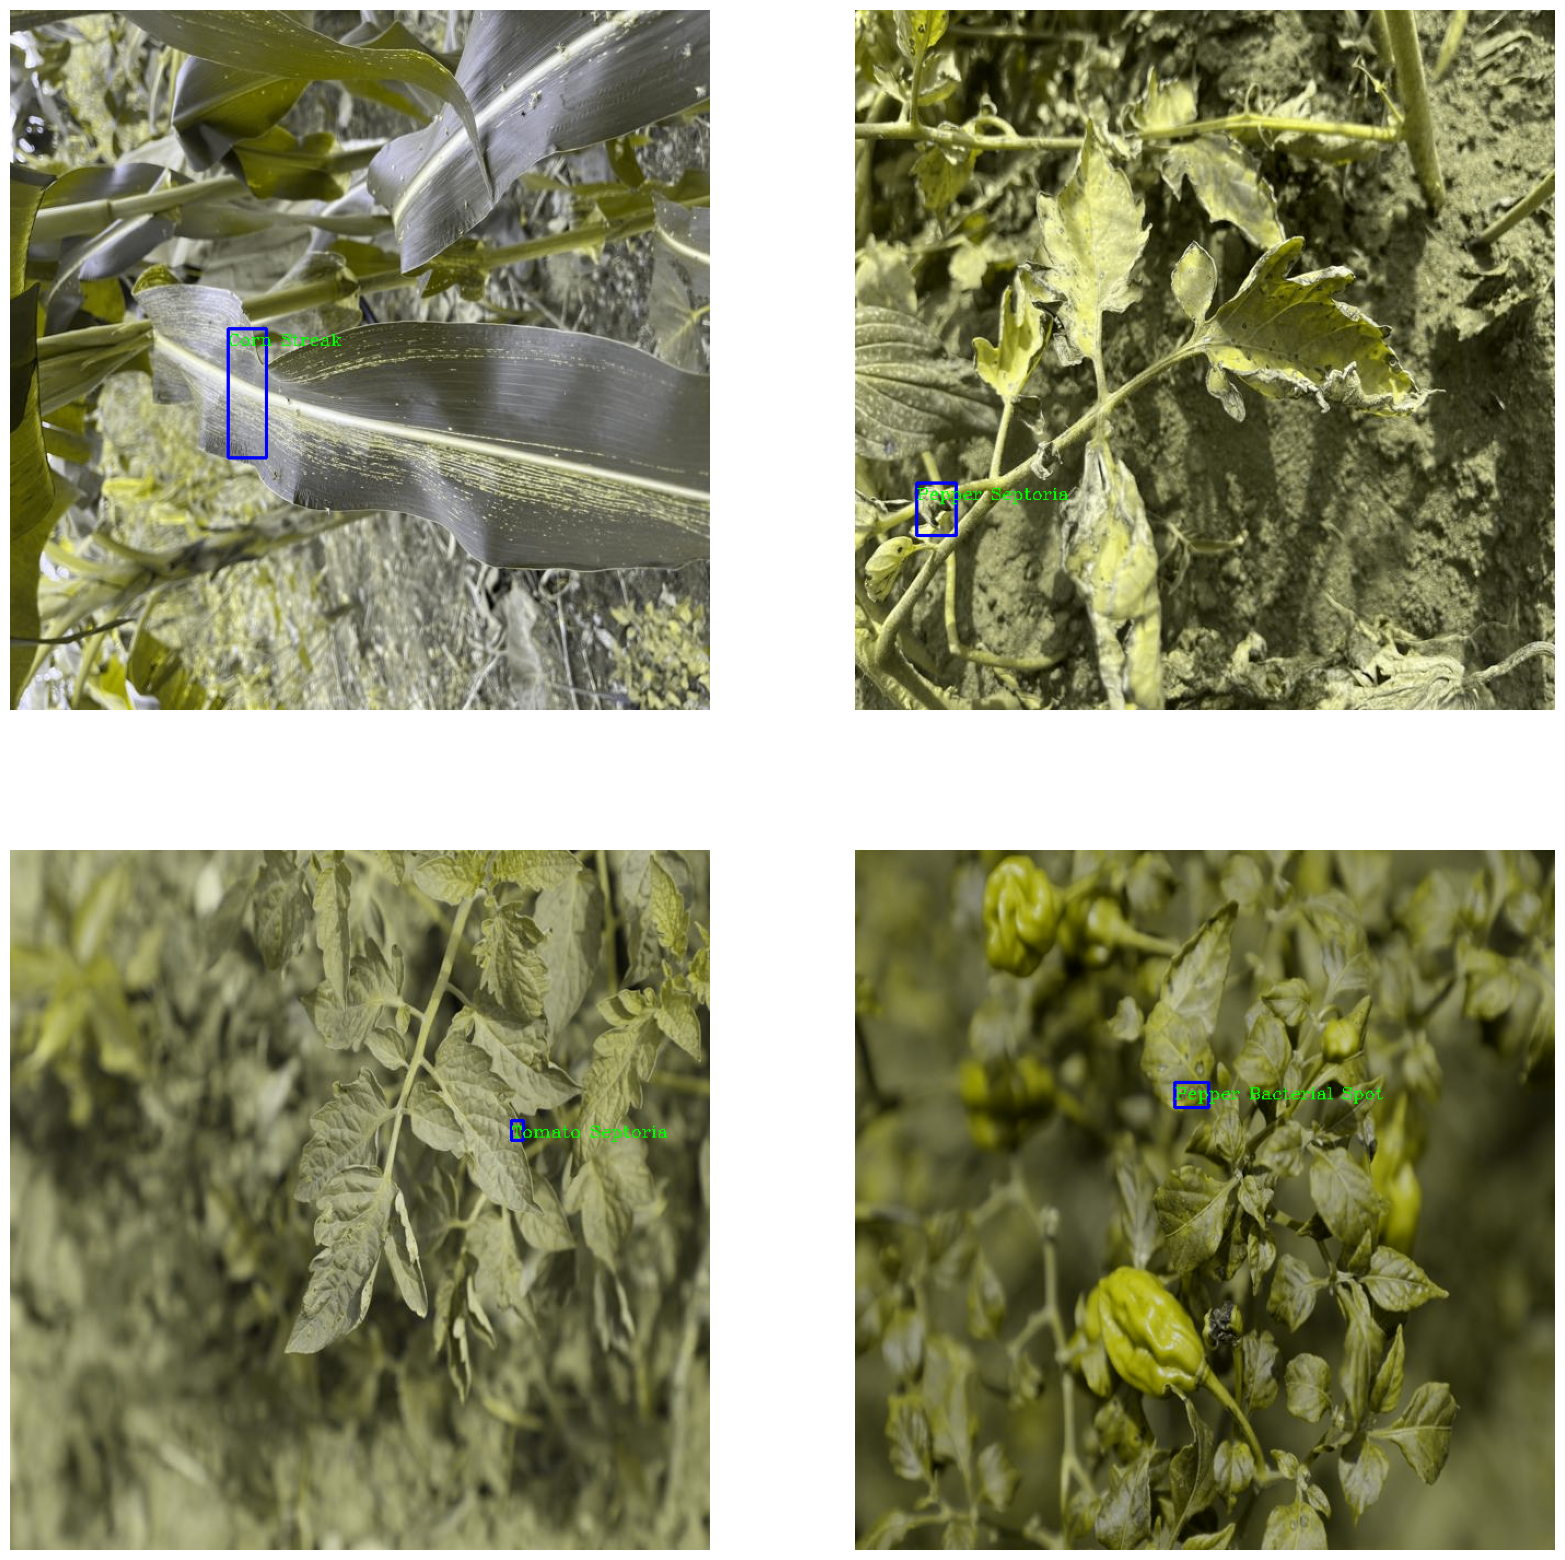

In [24]:
plt.figure(figsize=(20,20))
for i, (image, target) in enumerate(zip(images, targets)):
    plt.subplot(2,2, i+1)
    boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
    sample = images[i].permute(1,2,0).cpu().numpy()
    names = targets[i]['labels'].cpu().numpy().astype(np.int64)
    for i,box in enumerate(boxes):
        cv2.rectangle(
            sample,
            (box[0], box[1]),
            (box[2], box[3]),
            (0, 0, 220), 2
        )
        cv2.putText(sample, classes[names[i]], (box[0],box[1]+15),cv2.FONT_HERSHEY_COMPLEX ,0.5,(0,220,0),1,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)

In [25]:
# load a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT) # pretrained=True  # weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 243MB/s]


In [26]:
num_classes = 23

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [27]:
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [28]:
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-82hlicv_
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-82hlicv_
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Created wheel for pycocotools: filename=pycocotools-2.0-cp310-cp310-linux_x86_64.whl size=92948 sha256=911695ce3670e77e97d075882e57492f7b3652b15e403781a791c628fa94788f
  Stored in directory: /tmp/pip-ephem-wheel-cache-e8eowc87/wheels/39/61/b4/480fbddb4d3d6bc34083e7397bc6f5d1381f79acc68e9f3511
Successfully built pycocotools


In [29]:
!git clone https://github.com/pytorch/vision.git
!cd vision;cp references/detection/utils.py ../;cp references/detection/transforms.py ../;cp references/detection/coco_eval.py ../;cp references/detection/engine.py ../;cp references/detection/coco_utils.py ../

Cloning into 'vision'...
remote: Enumerating objects: 493871, done.
remote: Counting objects: 100% (7481/7481), done.
remote: Compressing objects: 100% (465/465), done.
remote: Total 493871 (delta 7041), reused 7427 (delta 7002), pack-reused 486390
Receiving objects: 100% (493871/493871), 957.29 MiB | 38.81 MiB/s, done.
Resolving deltas: 100% (460276/460276), done.


In [30]:
from engine import train_one_epoch, evaluate
import utils

In [31]:
%%time
# let's train it for 2 epochs
num_epochs = 4

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, train_data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, valid_data_loader, device=device)

Epoch: [0]  [    0/10213]  eta: 12:28:36  lr: 0.000010  loss: 3.9026 (3.9026)  loss_classifier: 3.4520 (3.4520)  loss_box_reg: 0.0279 (0.0279)  loss_objectness: 0.4135 (0.4135)  loss_rpn_box_reg: 0.0091 (0.0091)  time: 4.3980  data: 1.1457  max mem: 3043
Epoch: [0]  [   10/10213]  eta: 3:06:15  lr: 0.000060  loss: 3.6352 (3.7210)  loss_classifier: 3.3720 (3.3827)  loss_box_reg: 0.0075 (0.0150)  loss_objectness: 0.2166 (0.3103)  loss_rpn_box_reg: 0.0091 (0.0131)  time: 1.0953  data: 0.1166  max mem: 3045
Epoch: [0]  [   20/10213]  eta: 2:38:47  lr: 0.000110  loss: 3.5569 (3.6419)  loss_classifier: 3.2657 (3.2339)  loss_box_reg: 0.0077 (0.0135)  loss_objectness: 0.2180 (0.3758)  loss_rpn_box_reg: 0.0080 (0.0187)  time: 0.7615  data: 0.0138  max mem: 3045
Epoch: [0]  [   30/10213]  eta: 2:29:25  lr: 0.000160  loss: 3.1331 (3.3999)  loss_classifier: 2.8729 (3.0353)  loss_box_reg: 0.0115 (0.0159)  loss_objectness: 0.2194 (0.3317)  loss_rpn_box_reg: 0.0073 (0.0170)  time: 0.7623  data: 0.013

In [32]:
import os 
import subprocess
from IPython.display import FileLink
os.makedirs('output')

In [33]:

def download_file(path, download_file_name):
    """
        download file/folder from the working directory
    """
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [34]:
torch.save(model.state_dict(), 'output/faster_rcnn_state.pth')

In [35]:
torch.save(model, 'output/faster_not_jit_rcnn_state.pt')

In [36]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('output/faster_rcnn_jit.pt') # Save

In [37]:
download_file('output', 'output')

/kaggle/working/output.zip

In [38]:
# load  a model; pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=None, weights_backbone=None)  # (pretrained=False, pretrained_backbone=False)

WEIGHTS_FILE = "output/faster_rcnn_state.pth"

num_classes = 23

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Load the traines weights
model.load_state_dict(torch.load(WEIGHTS_FILE))

model = model.to(device)

In [39]:
def obj_detector(img):
    img = cv2.imread(img, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)


    img /= 255.0
    img = torch.from_numpy(img)
    img = img.unsqueeze(0)
    img = img.permute(0,3,1,2)
    
    model.eval()

#     detection_threshold = 0.70
    
    img = list(im.to(device) for im in img)
    output = model(img)

    for i , im in enumerate(img):
        boxes = output[i]['boxes'].data.cpu().numpy()
        scores = output[i]['scores'].data.cpu().numpy()
        labels = output[i]['labels'].data.cpu().numpy()

#         labels = labels[scores >= detection_threshold]
#         boxes = boxes[scores >= detection_threshold].astype(np.int32)
#         scores = scores[scores >= detection_threshold]

#         boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
#         boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    
    sample = img[0].permute(1,2,0).cpu().numpy()
    sample = np.array(sample)
    boxes = output[0]['boxes'].data.cpu().numpy()
    name = output[0]['labels'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    boxes = boxes.astype(np.int32)
    names = name.tolist()
    
    return names, boxes, sample

In [40]:
pred_path = "/kaggle/input/crop-data/dataset/test"
pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]

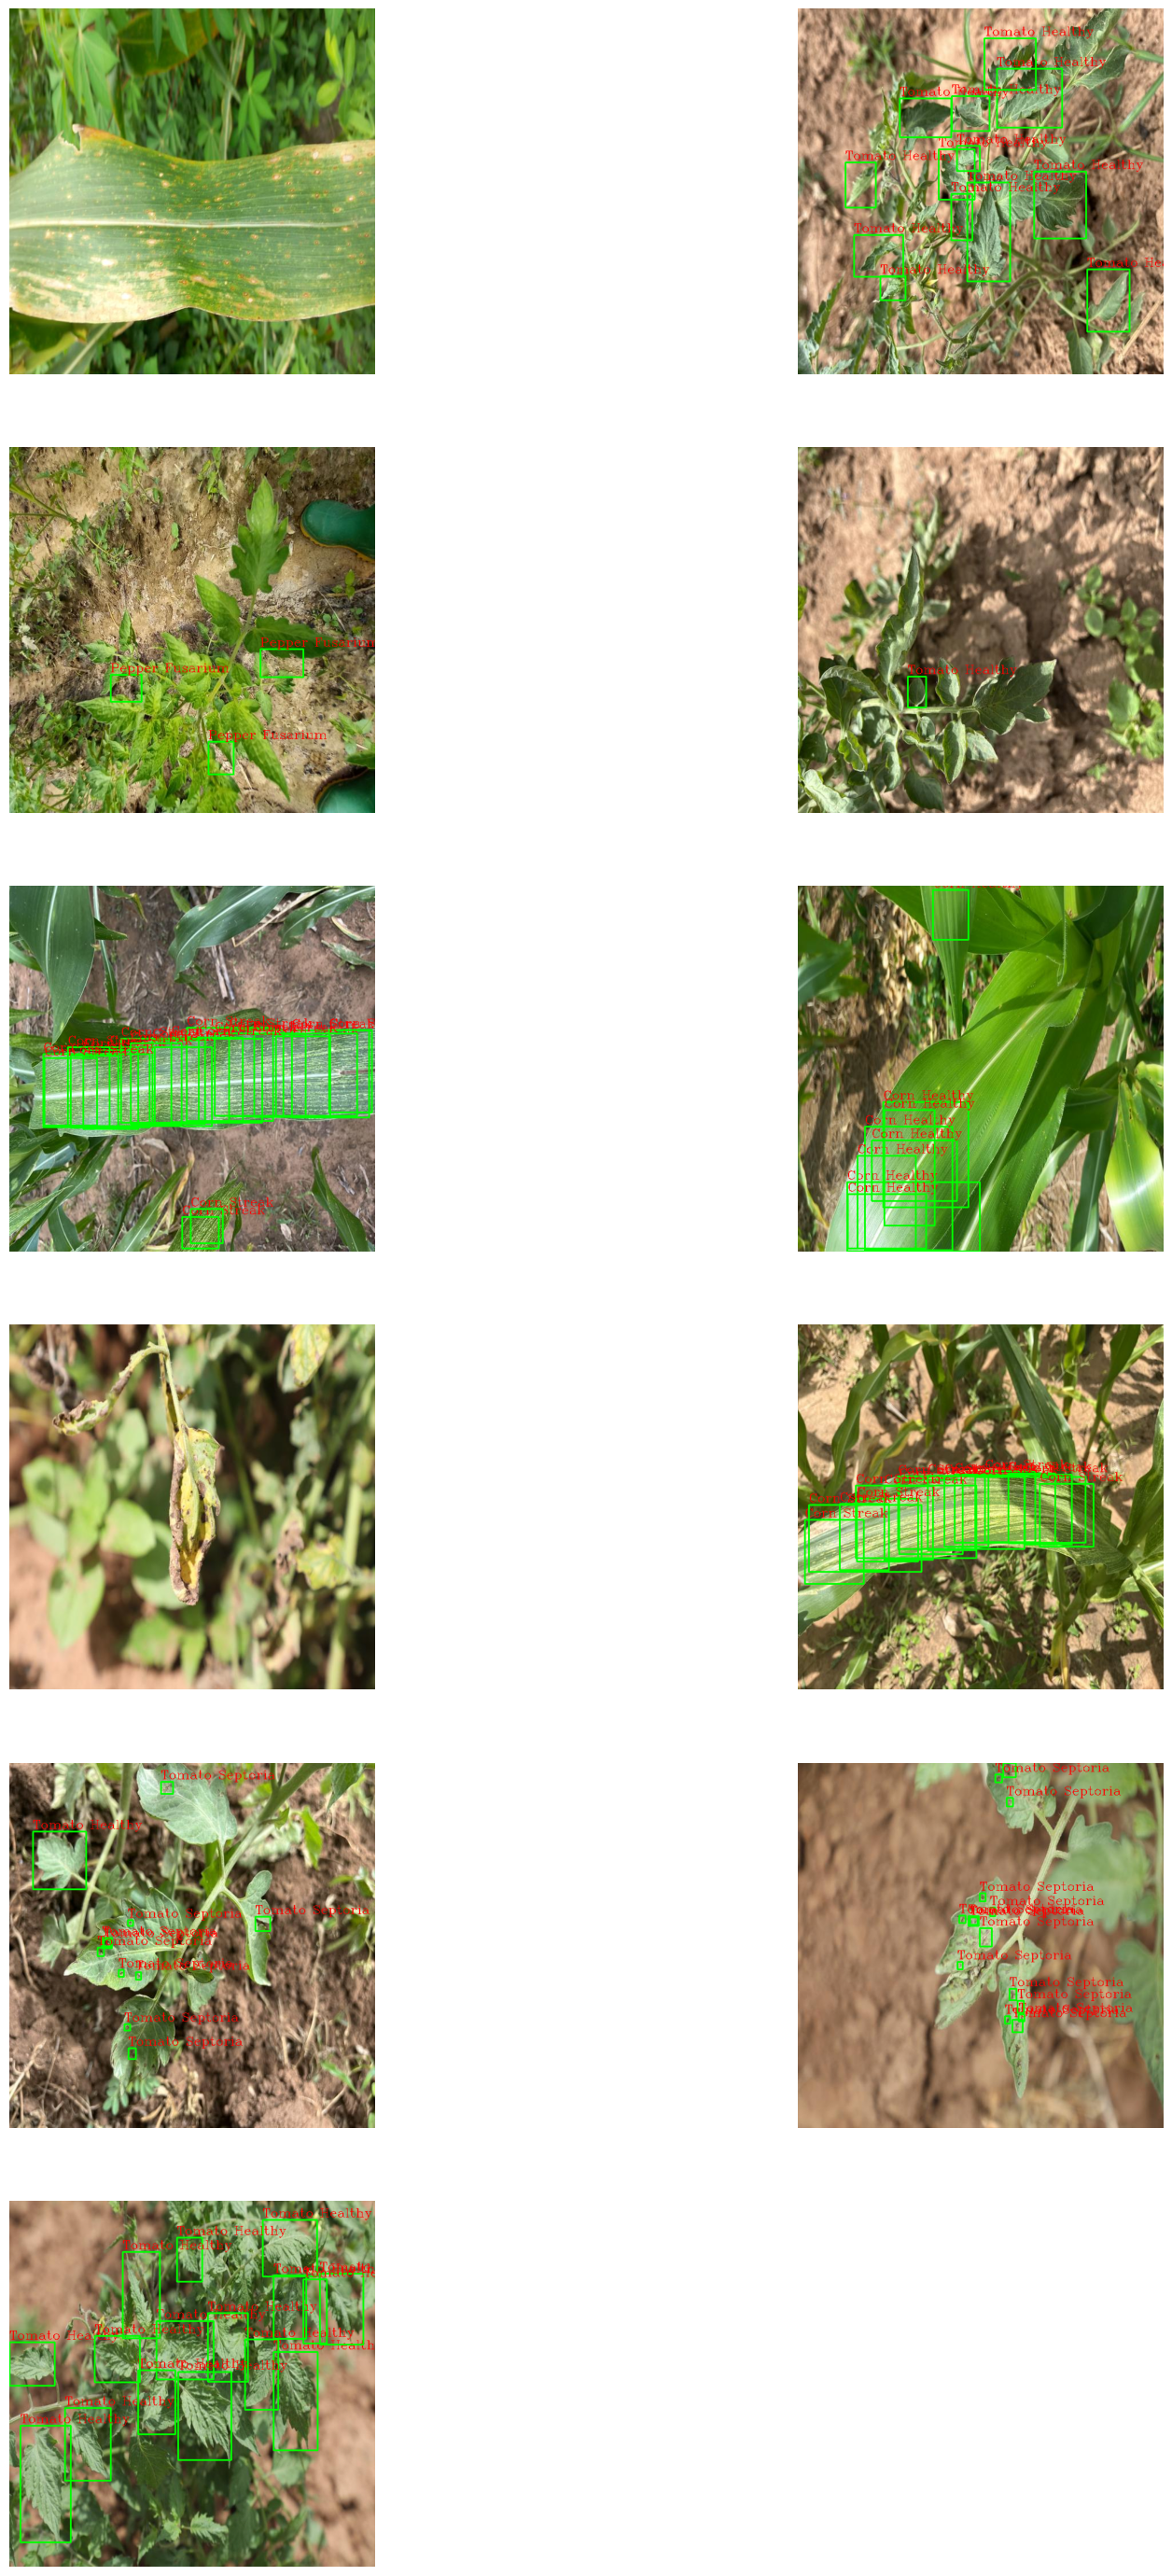

In [41]:
plt.figure(figsize=(20,60))
for i, images in enumerate(pred_files):
    if i > 10:break
    plt.subplot(10,2,i+1)
    names,boxes,sample = obj_detector(images)
    for i,box in enumerate(boxes):
        cv2.rectangle(
            sample,
            (box[0], box[1]),
            (box[2], box[3]),
            (0, 220, 0), 2
        )
        cv2.putText(sample, classes[names[i]], (box[0],box[1]-5),cv2.FONT_HERSHEY_COMPLEX ,0.7,(220,0,0),1,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)
#     plt.savefig('save_image.png', bbox_inches='tight')  # if you want to save result